In [1]:
from utils.binaries import *
from utils.plotting import *
from utils.auger.fd import XYScanner
from datetime import datetime
from utils import CONSTANTS


21:00:31 (   +3.0s) [INFO   ] -- import logging
21:00:31 (  +170ms) [INFO   ] -- import numpy as np
21:00:31 (    +9ms) [INFO   ] -- import uncertainties
21:00:32 (  +408ms) [INFO   ] -- import pandas as pd
21:00:32 (    +1ms) [WARNING] -- pandas support to be dropped at some point!
21:00:32 (    +2ms) [INFO   ] -- import binaries.tools as tools
21:00:32 (  +384ms) [INFO   ] -- import matplotlib.pyplot as plt
21:00:33 (  +666ms) [INFO   ] -- import seaborn as so
21:00:33 (    +9ms) [INFO   ] -- set MONI_PATH = PosixPath('/cr/work/filip/monit_and_sd')
21:00:33 (    +1ms) [INFO   ] -- set HIST_PATH = PosixPath('/cr/work/filip/monit_and_sd')
21:00:33 (    +1ms) [INFO   ] -- set PLOT_PATH = PosixPath('/cr/data01/filip/plots')
21:00:33 (    +1ms) [INFO   ] -- set DATA_PATH = PosixPath('/cr/data01/filip/Data')
21:00:33 (    +1ms) [INFO   ] -- set SCAN_PATH = PosixPath('/cr/data01/filip/xy-calibration')
21:00:33 (    +0ms) [INFO   ] -- set OFLN_PATH = PosixPath('/cr/data01/filip/offline/insta

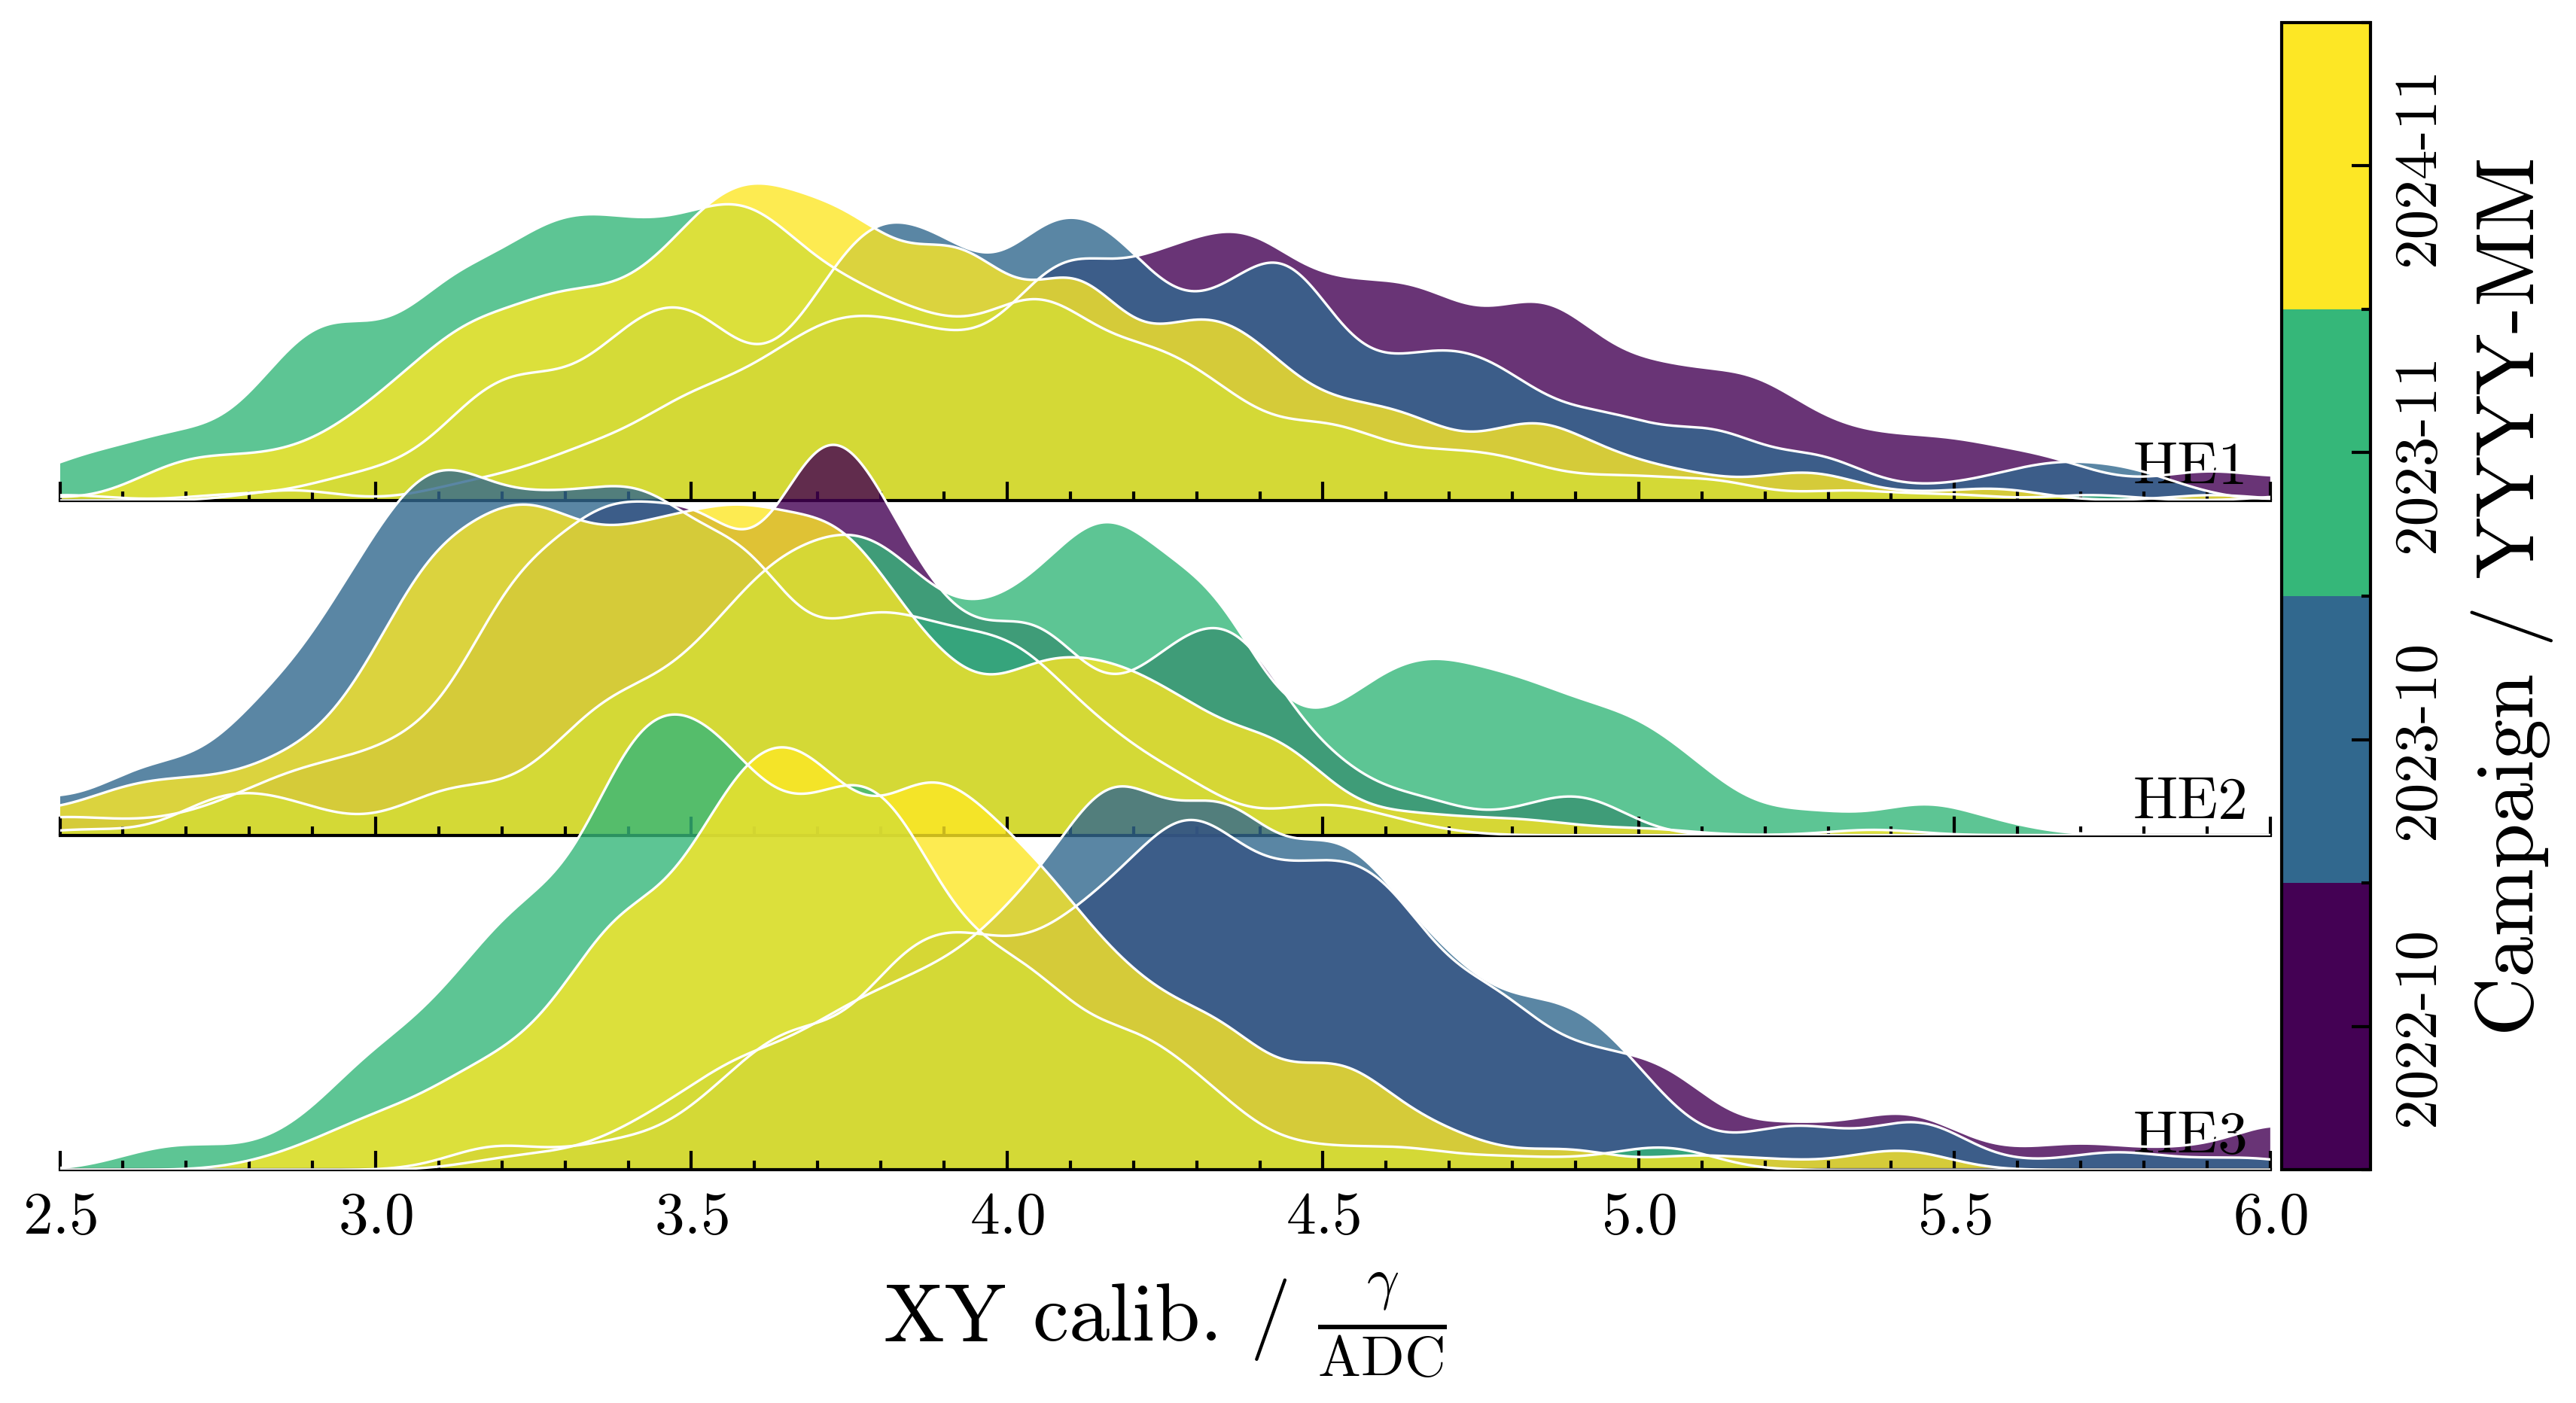

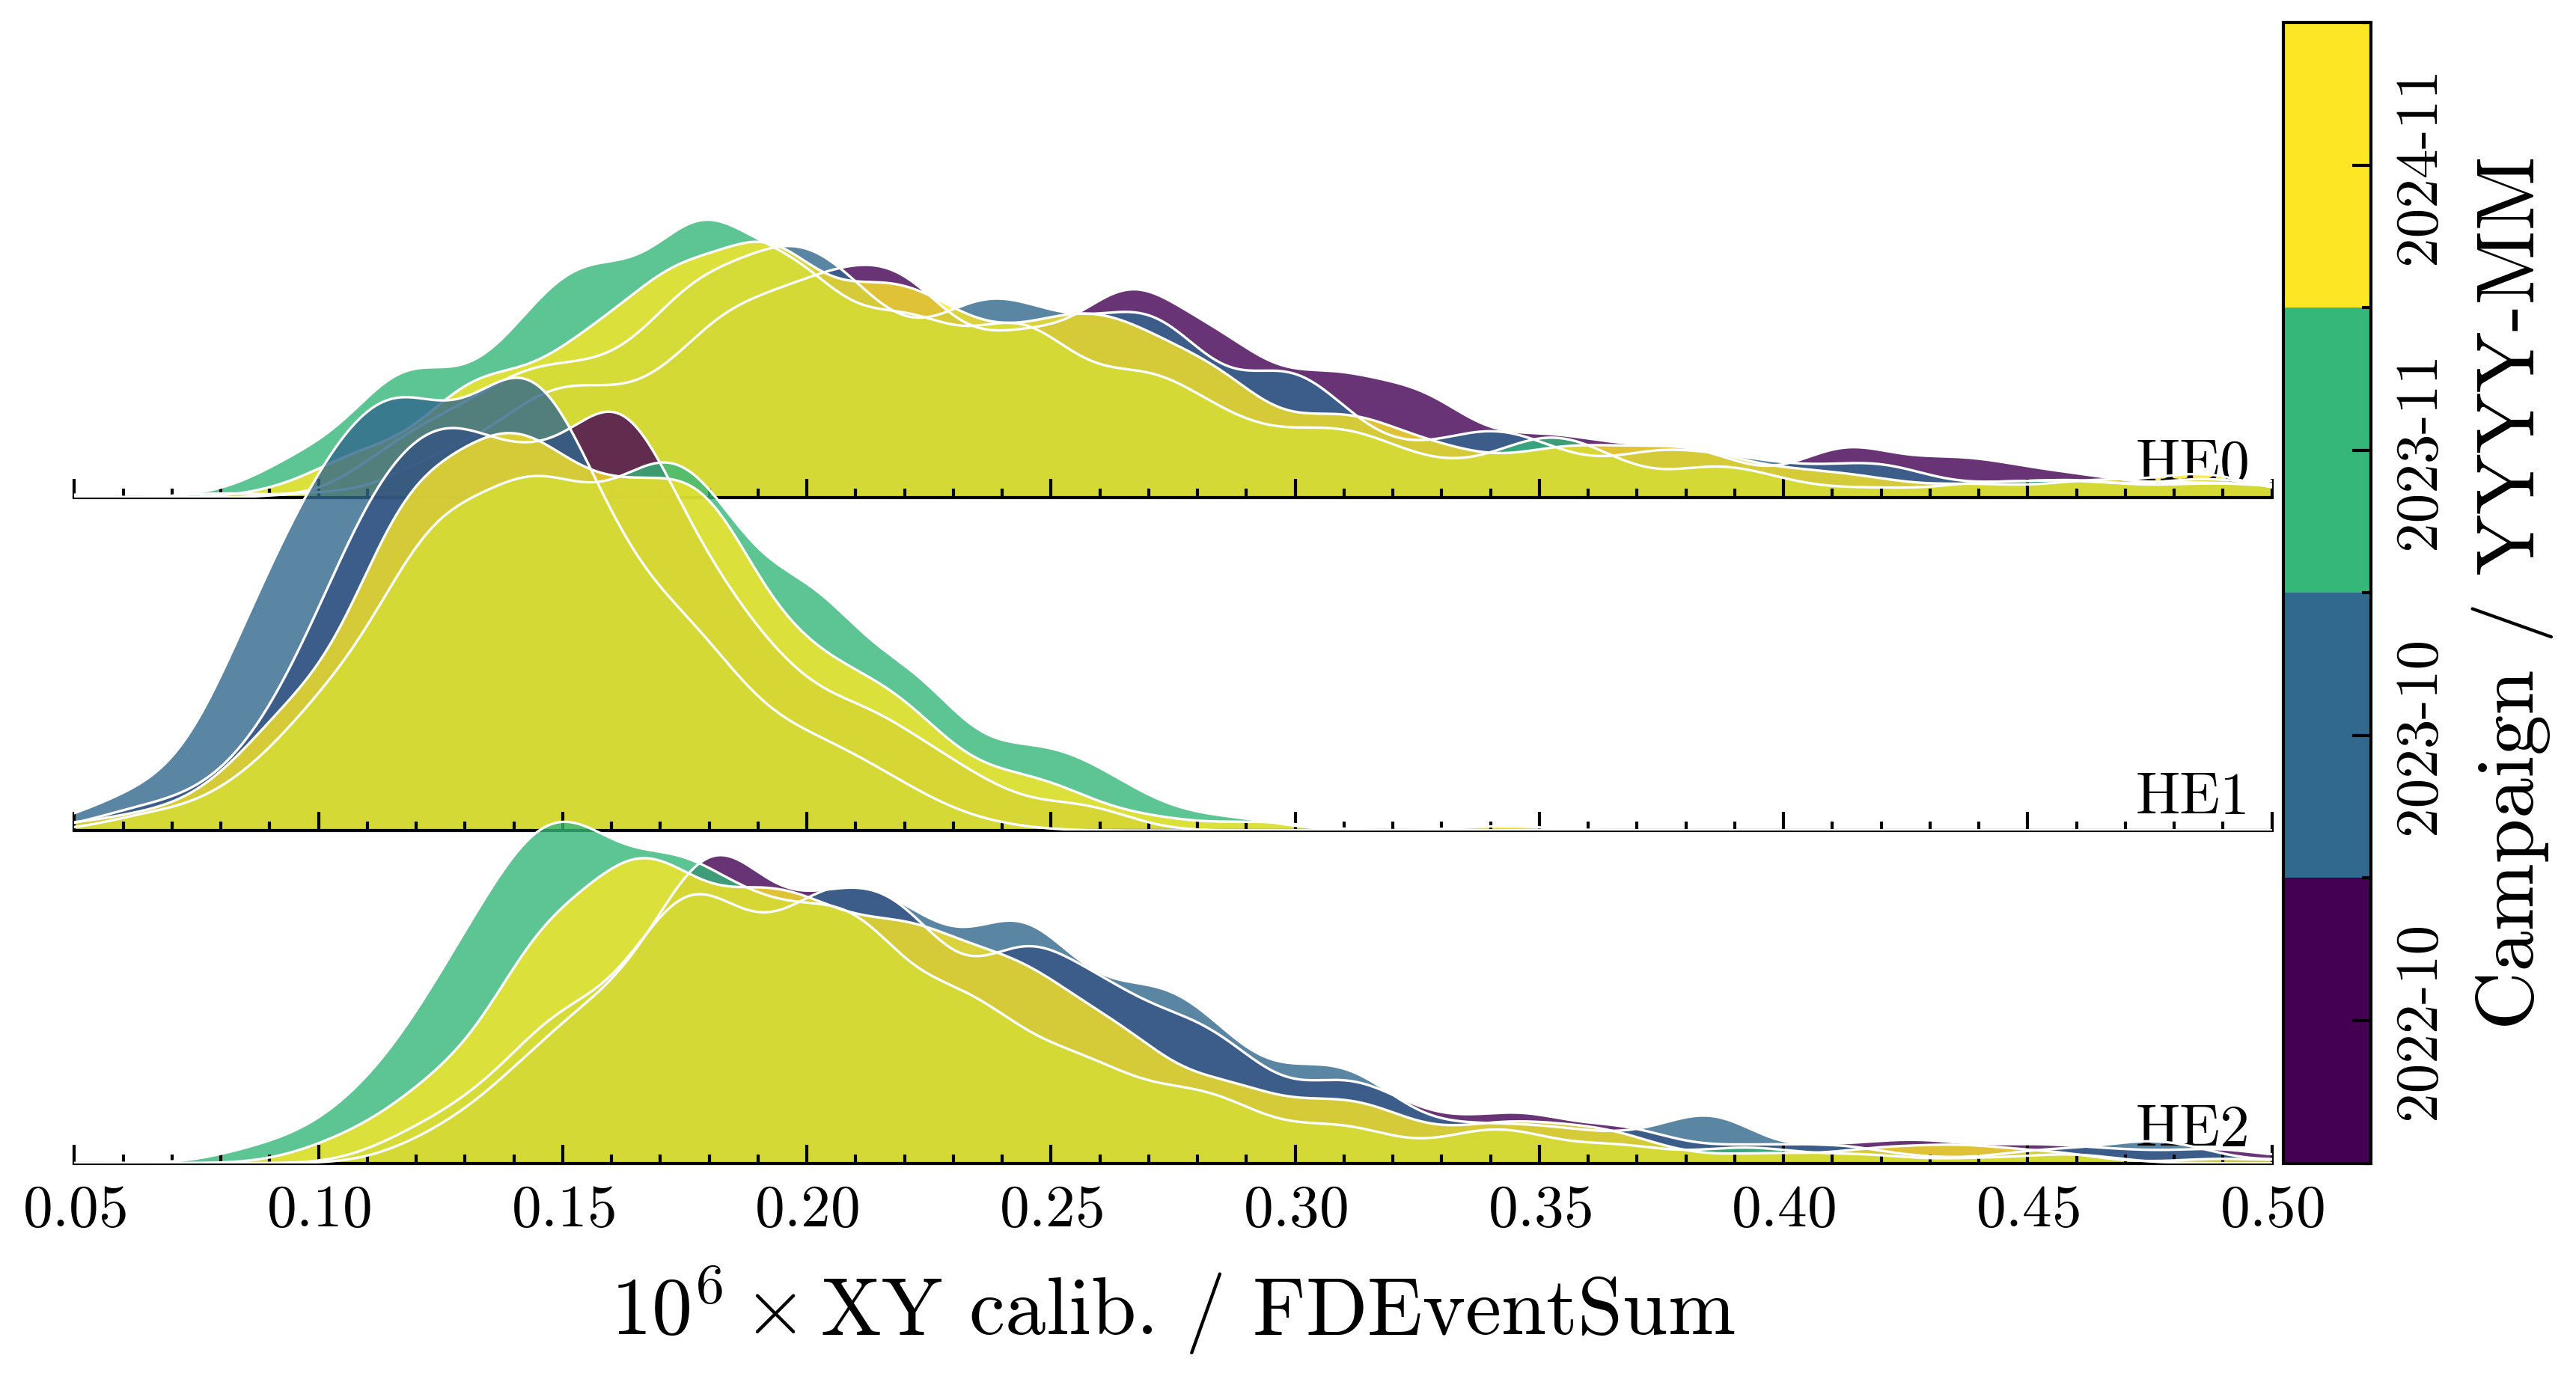

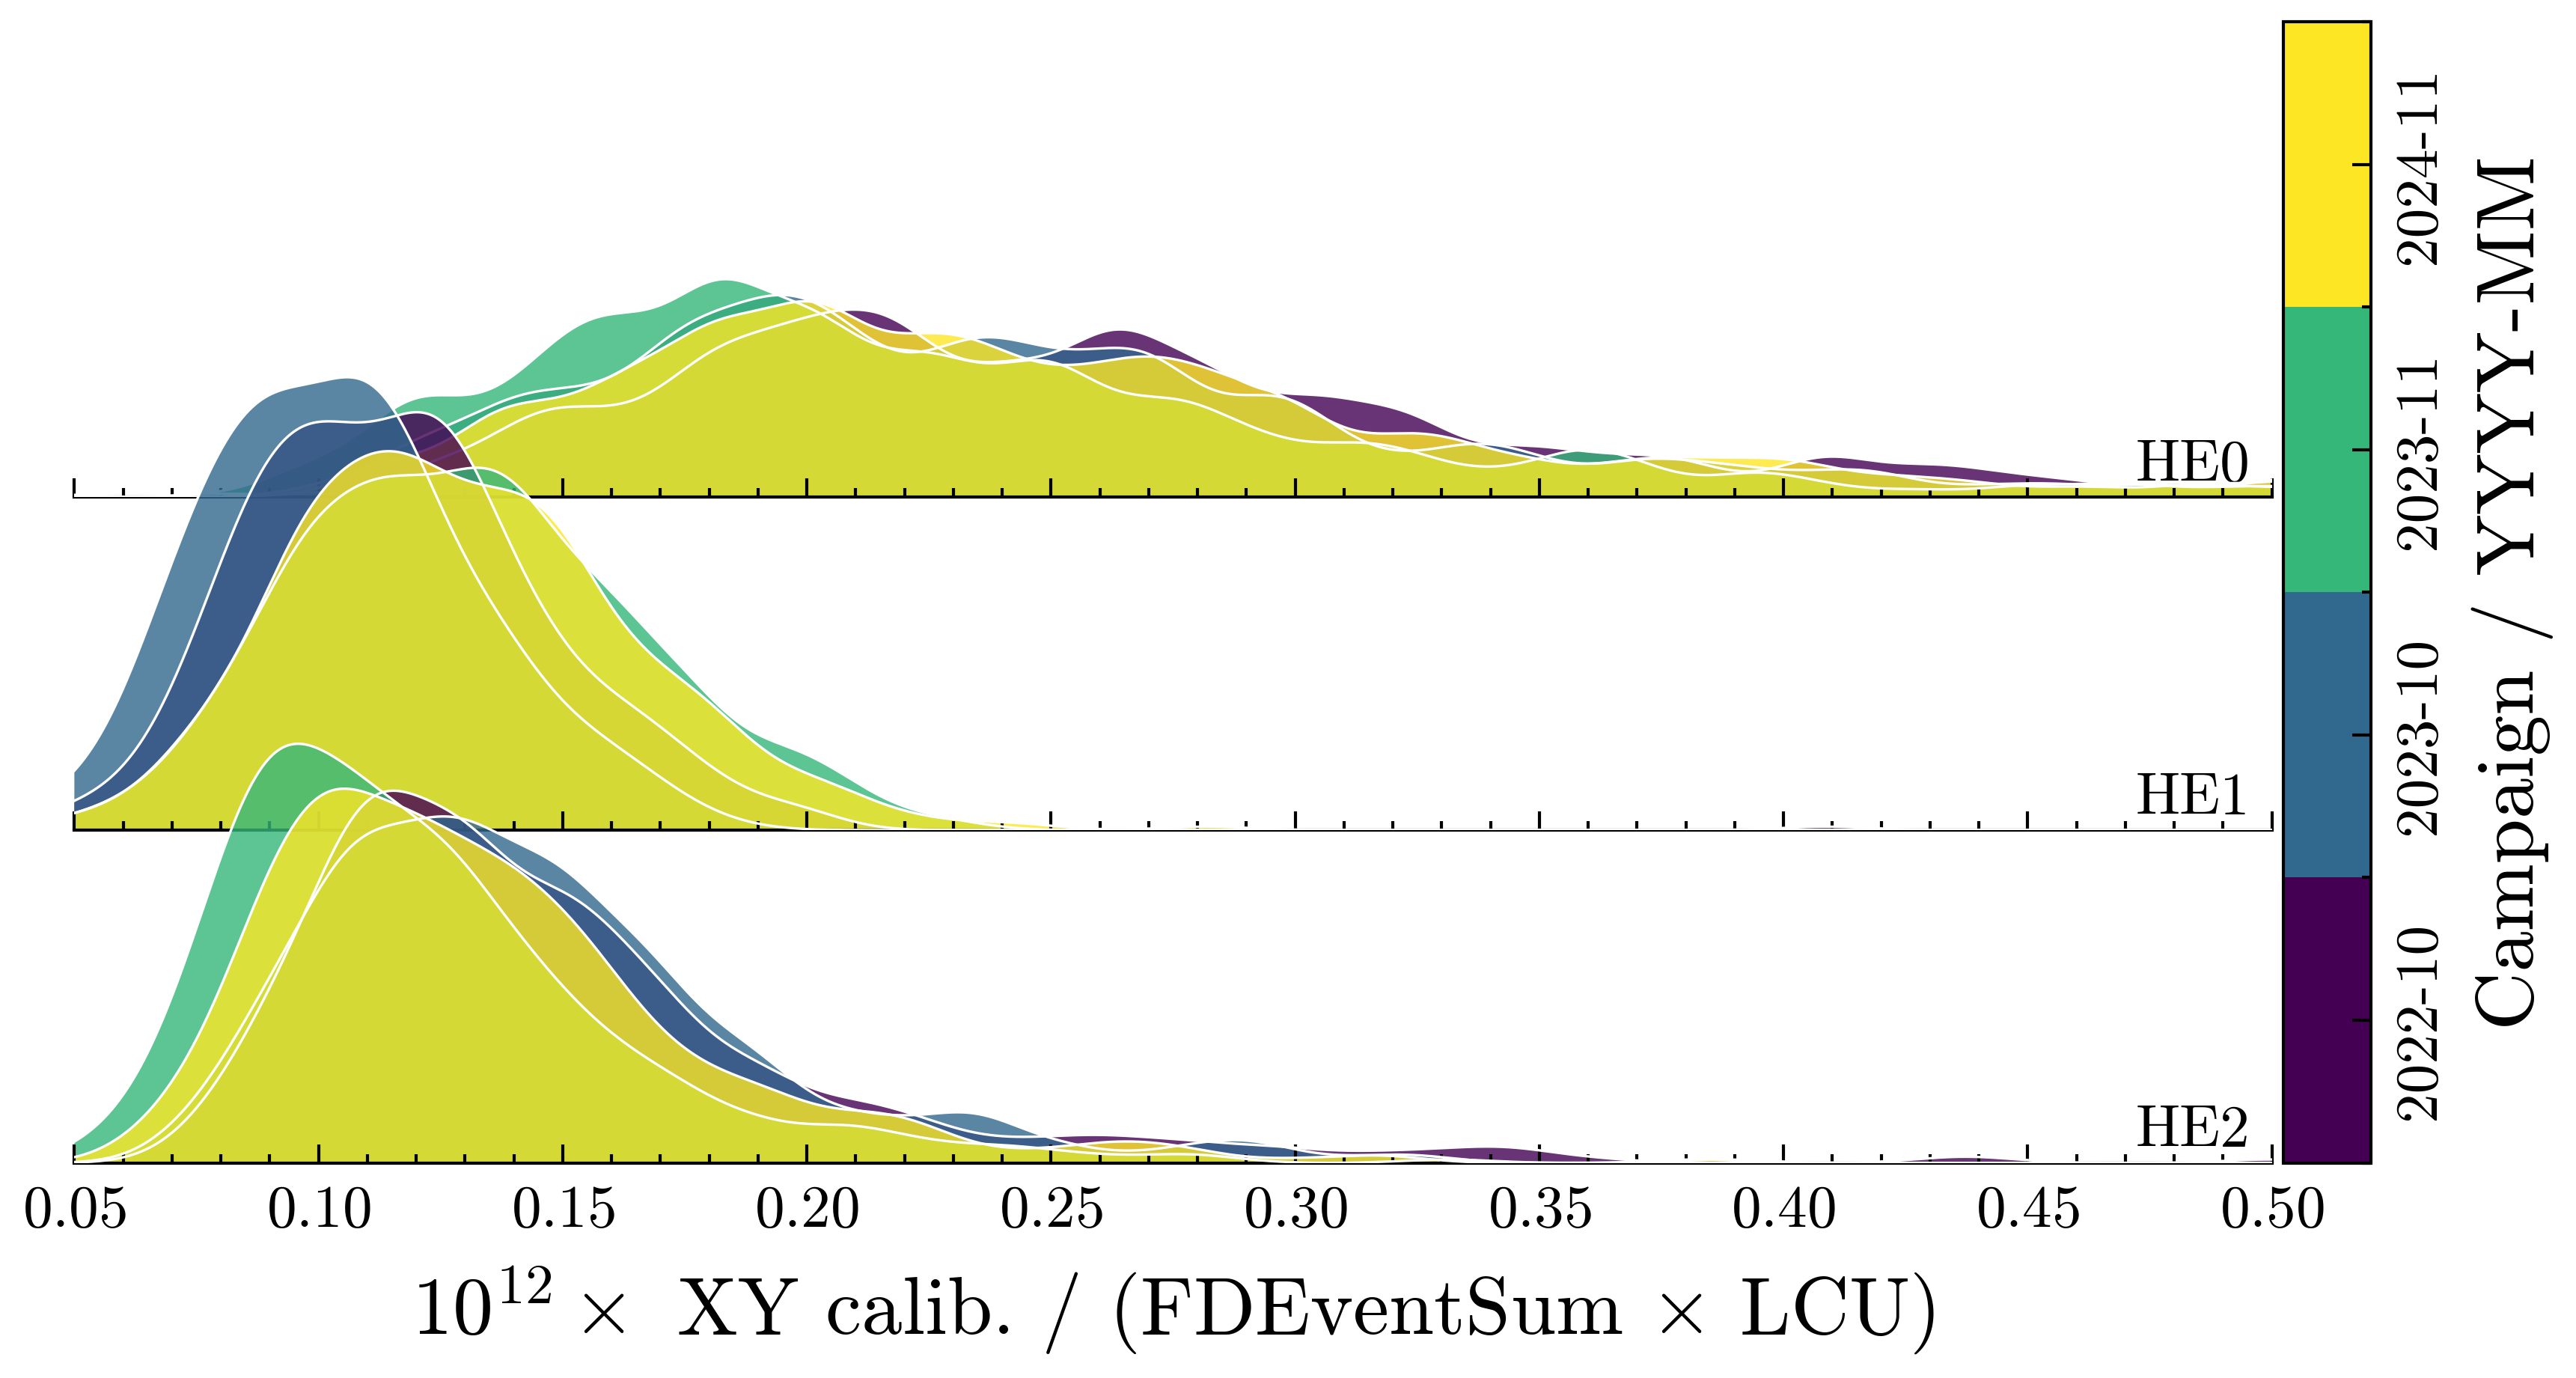

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages

campaign_dates = ["2022-10", "2023-10", "2023-11", "2024-11"]
create_empty = lambda s: np.array([[[np.nan] * 440] * 4] * s)

for site in ["LL", "LM", "LA", "CO", "HE"]:

    pdf = PdfPages(CONSTANTS.PLOT_PATH / f"xy_ridgeplots/{site}.pdf")

    data_raw = create_empty(3)
    data_gain = create_empty(3)
    data_lcu = create_empty(3)

    for i in range(3):

        extension = site.lower() if site.lower() != "he" else f"he{i+1}"
        lcu_time = tools.pickle_load(f"/cr/tempdata01/filip/LCUDATA/data/x.{extension}")
        lcu_data = tools.pickle_load(f"/cr/tempdata01/filip/LCUDATA/data/y.{extension}")

        tel = XYScanner.Telescope(f"{site}{i+1}")

        for run in tel:
            if run.year_month_day.startswith("2019"): continue
            if run.source != "OLO": continue
            if run.stepsize != 6: continue
            if run.year_month_day.startswith("2024-12"): 
                run.year_month_day = "2024-11-30"
            j = campaign_dates.index(run.year_month_day[:-3])

            this_raw = run.get_data("XY")
            this_preXY = run.get_data("preXY")
            this_postXY = run.get_data("postXY")
            if this_raw is None \
            or this_preXY is None \
            or this_postXY is None: continue

            this_gain = this_raw / (0.5 * (this_preXY + this_postXY))

            # raise a warning if found closest index is last index
            # likely we need to get more data from lyon LCU files
            # don't forget to recreate {x,y}.* files via read_dat.ipynb
            run_time = datetime.strptime(run.year_month_day, "%Y-%m-%d")
            idx = tools.closest(lcu_time, run_time)

            if idx + 1 == len(lcu_time): raise ValueError(f"get more LCU data for {site = }!")
            this_lcu = this_gain / lcu_data[idx]
            data_raw[i, j] = this_raw
            data_gain[i, j] = this_gain
            data_lcu[i, j] = this_lcu


    raw = plot.ridgeplot2d(data_raw, 
                           cbar_ticks=campaign_dates, 
                           labels=[f"{site}{i}" for i in range(1, 7)],
                           xlabel=r"XY calib. / $\frac{\gamma}{\mathrm{ADC}}$",
                           ylabel="Campaign / YYYY-MM",
                           xmin=2.5, xmax=6)
    pdf.savefig(raw)
    plt.close(raw)
    

    gain = plot.ridgeplot2d(data_gain * 1e6, 
                            cbar_ticks=campaign_dates, 
                            labels=[f"{site}{i}" for i in range(6)],
                            xlabel=r"$10^6\times$XY calib. / FDEventSum",
                            ylabel="Campaign / YYYY-MM",
                            xmin=0.05, xmax=0.5)
    pdf.savefig(gain)
    plt.close(gain)

    

    lcu = plot.ridgeplot2d(data_lcu * 1e12, 
                           cbar_ticks=campaign_dates, 
                           labels=[f"{site}{i}" for i in range(6)],
                           xlabel=r"$10^{12}\times$ XY calib. / (FDEventSum $\times$ LCU)",
                           ylabel="Campaign / YYYY-MM",
                           xmin=0.05, xmax=0.5)
    pdf.savefig(lcu)
    plt.close(lcu)
    pdf.close()

In [ ]:
tel = XYScanner.Telescope("HE1")

for run in tel:
    print(run)